In [1]:
import numpy as np
from astropy.io import fits
from loguru import logger
from pathlib import Path

from surfh.Models import instru

from sklearn.decomposition import PCA

In [14]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import ndimage

# with fits.open('/home/nmonnier/Data/JWST/Orion_bar/Scan/ChannelCube_ch2-shortmediumlong_s3d.fits', mode='update') as hdul1:
#     # Change something in hdul.
#     hdul1[1].data = ndimage.median_filter(hdul1[1].data, axes=[0])
#     hdul1.flush()  # changes are written back to original.fits



hdul = fits.open('/home/nmonnier/Data/JWST/Orion_bar/Scan/overwritten_ChannelCube_ch2-shortmediumlong_s3d.fits')
data = hdul[1].data
print(data.shape)
data_filtered = ndimage.median_filter(data.copy(), size=11, axes=[0])


hdr = hdul[1].header

(3224, 171, 91)


In [12]:
wavel = (np.arange(hdr['NAXIS3']) +hdr['CRPIX3'] - 1) * hdr['CDELT3'] + hdr['CRVAL3']
# Select petite portion de la bar, où il y a de l'information
sel_data = data[:,:50, :50]
nsel_data = sel_data[:,15:37, 8:37]

sel_data_filtered = data_filtered[:,:50, :50]
nsel_data_filtered = sel_data_filtered[:,15:37, 8:37]


# Reshape 3D to 2D
spectro = nsel_data.reshape(nsel_data.shape[0],nsel_data.shape[1]*nsel_data.shape[2])
spectro_filtered = nsel_data_filtered.reshape(nsel_data_filtered.shape[0],nsel_data_filtered.shape[1]*nsel_data_filtered.shape[2])


# Create a mask of where the NaNs are
nan_mask = np.isnan(spectro)
nan_mask_filtered = np.isnan(spectro_filtered)

# Find the indices of non-NaN values
indices = ndimage.distance_transform_edt(nan_mask, return_distances=False, return_indices=True)
indices_filtered = ndimage.distance_transform_edt(nan_mask_filtered, return_distances=False, return_indices=True)

# Replace NaNs with nearest non-NaN values using the indices
filled_image = spectro[tuple(indices)]
filled_image_filtered = spectro_filtered[tuple(indices_filtered)]

Text(0.5, 0, 'Wavelength $\\lambda$')

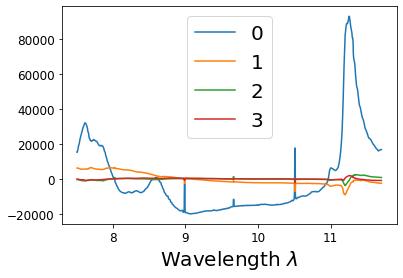

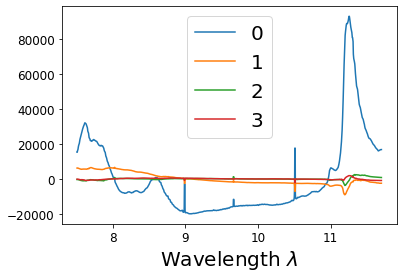

In [13]:

pca = PCA(n_components=4)
principal_components = pca.fit_transform(filled_image)
principal_components_filtered = pca.fit_transform(filled_image_filtered)

principal_components = principal_components.T
plt.figure()
for i in range(4):
    plt.plot(wavel, principal_components[i], label=i)
plt.legend(fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Wavelength $\lambda$", fontsize=20)

principal_components_filtered = principal_components_filtered.T
plt.figure()
for i in range(4):
    plt.plot(wavel, principal_components_filtered[i], label=i)
plt.legend(fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Wavelength $\lambda$", fontsize=20)

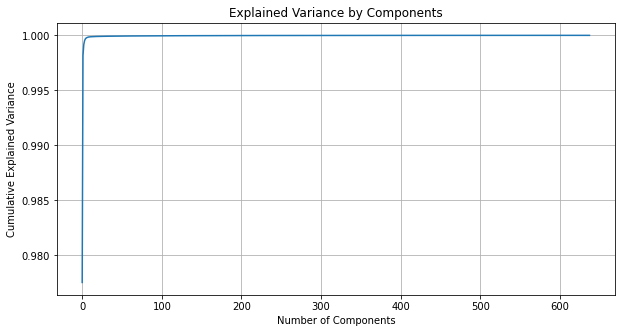

In [5]:
# Perform PCA
pca = PCA()  # Not limiting the number of components
pca.fit(filled_image)

# Explained variance
explained_variance = pca.explained_variance_ratio_
# Plot the explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)

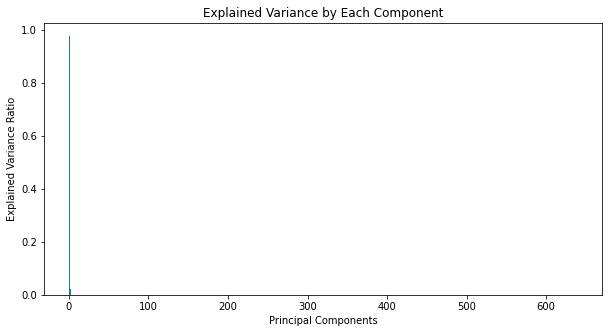

In [6]:
# Optional: Plot the explained variance of individual components
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Each Component')
# plt.yscale('log')


# Correct bad slices
corrected_filled_image = np.copy(filled_image)
corrected_filled_image[np.where(wavel> 8.990) and np.where(wavel < 9.02)] = filled_image[0]
